In [41]:
import sys
import os

In [42]:
if (os.getcwd()[-3:] != 'src'):
    os.chdir('../src')
    sys.path.append(os.getcwd())
    os.chdir('../ComparisonWithWei')

In [43]:
import scipy
import math
import numpy as np
from diagonalize import State, delta, neg_1_pow, Interaction, Molecule
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import total_ordering
import matplotlib.image as mpimg
import xarray
int_wigner_arr = np.load("../src/wigner3j_integer_N=10.npy")
halfint_wigner_arr = np.load("../src/wigner3j_halfint_N=3.5.npy")
#plt.rcParams['text.usetex'] = True

In [44]:
def T_int(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

def T_half_int(n3, n1, m3, m1, n2, m2, N = 7/2):
    n3 = n3 - 0.5 
    n1 = n1 - 0.5 
    
    n2 = n2
    m2 = m2 + 2 
    
    m3 = m3 + N 
    m1 = m1 + N 
    
    return int(m2 + 5 * n2 + 15 * m1 + (15+30*N)*m3 + (15+60*N+60*N*N)*n1 + (60*N*N*N + 90*N*N + 45*N + 7.5)*n3)
    
#def wigner_3j(n1, n2, n3, m1, m2, m3):
#    if n1 == int(n1) and n2 == int(n2) and n3 == int(n3):
#        return int_wigner_arr[T_int(n3,n1,m3,m1,n2,m2)]
#    return halfint_wigner_arr[T_half_int(n3,n1,m3,m1,n2,m2)]

# we will use this to allow basises with Nmax above 10
from sympy.physics.wigner import wigner_3j

h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    return wig1 * wig2 * other

int_rotational = Interaction(1, rotational)
int_stark = Interaction(1, stark)

Nmax = 10
NaCs = Molecule(range(Nmax), 0, 0)
basis = NaCs.states
NaCs.add_interaction(int_rotational)
NaCs.add_changing_interaction(int_stark)

NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 8, int(81))
eigenvalues_and_eigenvectors_E = NaCs.compute_eigenval_over_range([E_range])
eigenvalues = [elem[0] for elem in eigenvalues_and_eigenvectors_E]
eigenvectors = [elem[1] for elem in eigenvalues_and_eigenvectors_E]


H has dim 100


In [45]:
@total_ordering
class pendularState:
    # eigenvalue is the energy of this state
    # eigenvector is the vector corresponding to the basis weights
    # of this state
    # index is the original index of this state, before resorting
    def __init__(self, eigenvalue, eigenvector, index, basis=None):
        self.eigenvalue = eigenvalue
        self.eigenvector = eigenvector
        self.index = index
        self.basis = basis

    def inner(self, other):
        # adjust later
        return 0
    
    def expectation(self, operator, other):
        # adjust later
        return 0

    def __lt__(self, other):
        return self.eigenvalue < other.eigenvalue

    def __eq__(self, other):
        return self.eigenvalue == other.eigenvalue
    

In [46]:
len(eigenvalues[0])

100

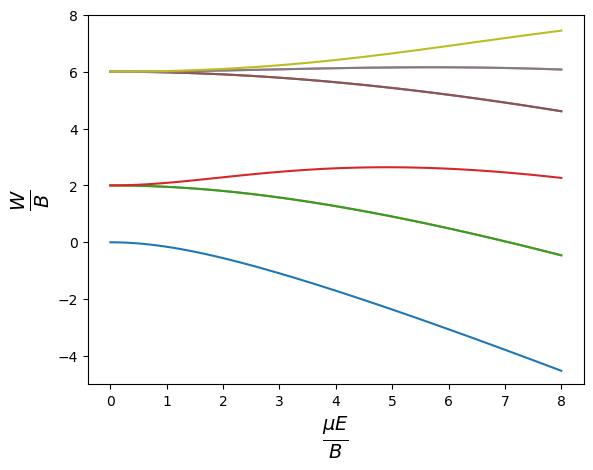

In [47]:
# each index of this array corresponds to a pendular basis
# with a different electric field strength
pendularBasises = []
for i in range(len(E_range)):
    myStates = []
    for j in range(len(eigenvalues[0])):
        myStates.append(pendularState(eigenvalues[i][j], eigenvectors[i][j], j))
    pendularBasises.append(sorted(myStates))

eigen_values_ordered_range = [[state.eigenvalue for state in states] for states in pendularBasises]
eigen_vectors_ordered_range = [[state.eigenvector for state in states] for states in pendularBasises]
plt.figure()
plt.plot(E_range, eigen_values_ordered_range)
plt.ylim(-5,8)
plt.xlabel(r'$\frac{\mu E}{B}$', fontsize = 20)
plt.ylabel(r'$\frac{W}{B}$', fontsize = 20)
plt.show()

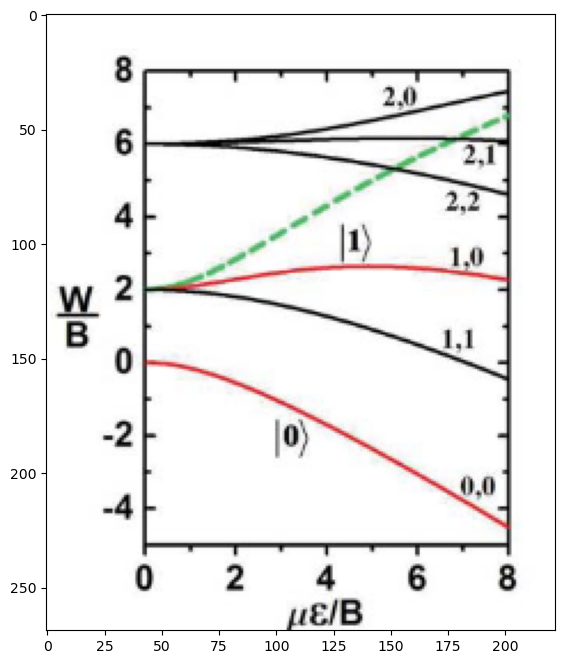

In [50]:
plt.figure(figsize=(15,8))
img = mpimg.imread('Wei1.png')
imgplot = plt.imshow(img)
plt.show()

In [48]:
first_3_eigen_ranges = [elem[:4] for elem in eigen_values_ordered_range]

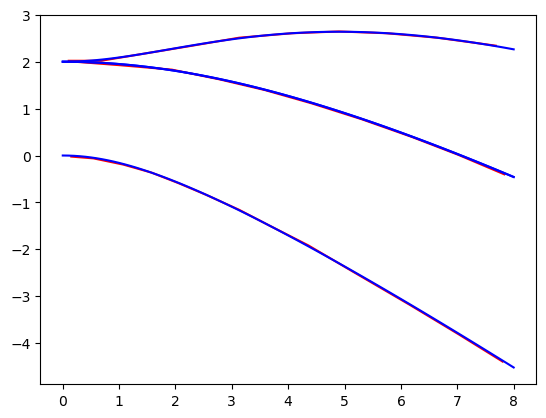

In [49]:
import pandas as pd

p_state_00 = pd.read_csv('plot-data-1.csv') 
p_state_10 = pd.read_csv('plot-data-2.csv')
p_state_11 = pd.read_csv('plot-data-3.csv')
plt.figure()
plt.plot(p_state_00['x'], p_state_00[' y'], 'r')
plt.plot(p_state_10['x'], p_state_10[' y'], 'r')
plt.plot(p_state_11['x'], p_state_11[' y'], 'r')

plt.plot(E_range, first_3_eigen_ranges, 'b')

[0, 2, 6, 12, 20, 30, 42, 56, 72, 90]
[0, 2, 6, 12, 20, 30, 42, 56, 72, 90]


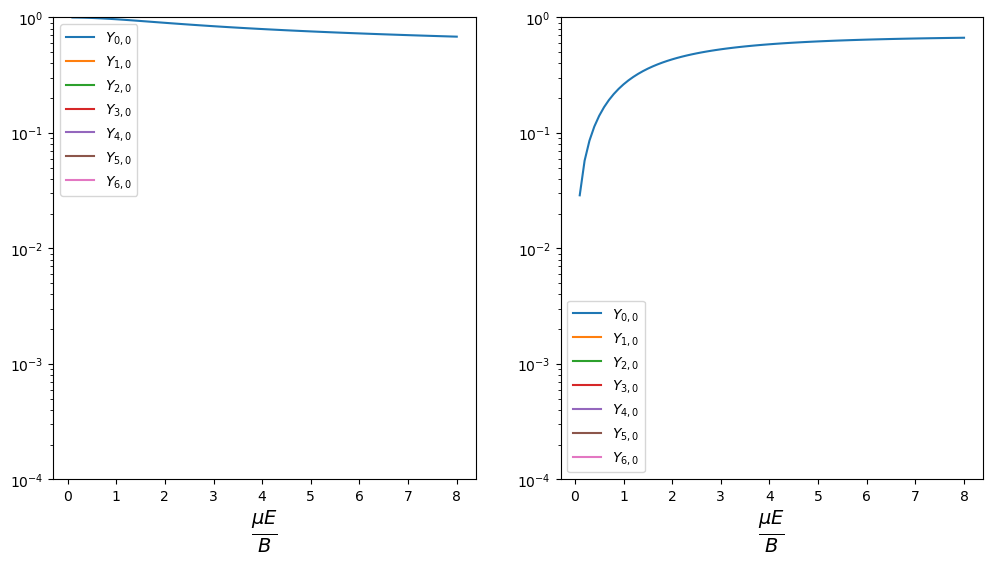

In [90]:
nstates = 2
nharmonics = 7
fig, ax = plt.subplots(1,nstates, figsize=(12,6))

j=0
indexrange = [i for i, elem in enumerate(eigen_vectors_ordered_range[59][j]) if basis[i].mn == 0]
print(indexrange)
coefficients_to_plot = np.array([[pbasis[j][i] for i in indexrange[:nharmonics]] for pbasis in eigen_vectors_ordered_range]).reshape(len(E_range),nharmonics)
ax[j].plot(E_range[1:], np.abs(coefficients_to_plot[1:]), label = ['$Y_{0,0}$','$Y_{1,0}$','$Y_{2,0}$','$Y_{3,0}$','$Y_{4,0}$','$Y_{5,0}$','$Y_{6,0}$'])
ax[j].set_xlabel(r'$\frac{\mu E}{B}$', fontsize = 20)
ax[j].set_yscale('log')
ax[j].set_ylim(1e-4,1)
ax[j].legend()

j=1
indexrange = [i for i, elem in enumerate(eigen_vectors_ordered_range[59][j]) if basis[i].mn == 0]
print(indexrange)
coefficients_to_plot = np.array([[pbasis[2][i] for i in indexrange[:nharmonics]] for pbasis in eigen_vectors_ordered_range]).reshape(len(E_range),nharmonics)
ax[j].plot(E_range[1:], np.abs(coefficients_to_plot[1:]), label = ['$Y_{0,0}$','$Y_{1,0}$','$Y_{2,0}$','$Y_{3,0}$','$Y_{4,0}$','$Y_{5,0}$','$Y_{6,0}$'])
ax[j].set_xlabel(r'$\frac{\mu E}{B}$', fontsize = 20)
ax[j].set_yscale('log')
ax[j].set_ylim(1e-4,1)
ax[j].legend()
plt.show()

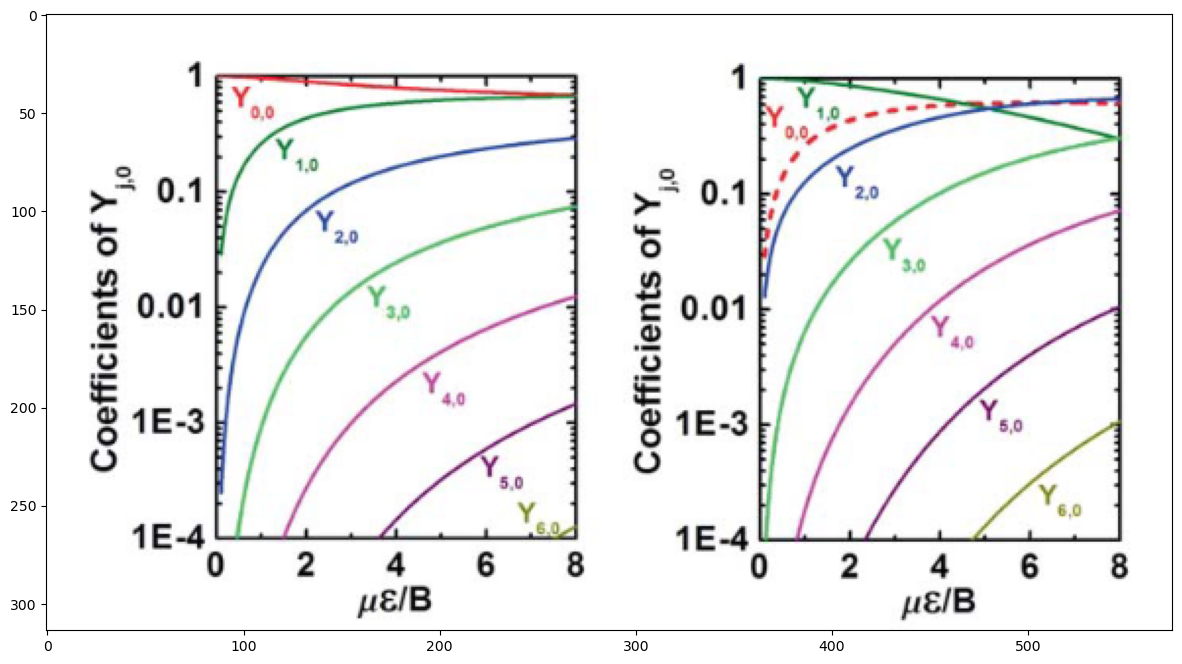

In [52]:
plt.figure(figsize=(20,8))
img = mpimg.imread('Wei2.png')
imgplot = plt.imshow(img)
plt.show()

In [53]:
import numpy as np
from scipy.special import sph_harm

In [54]:
def get_m0_state(l):
    return l*(l+1)

In [55]:
for i, elem in enumerate(basis):
    if i == get_m0_state(elem.n):
        print(elem)

n: 0, mn: 0, m1: 0, m2: 0
n: 1, mn: 0, m1: 0, m2: 0
n: 2, mn: 0, m1: 0, m2: 0
n: 3, mn: 0, m1: 0, m2: 0
n: 4, mn: 0, m1: 0, m2: 0
n: 5, mn: 0, m1: 0, m2: 0
n: 6, mn: 0, m1: 0, m2: 0
n: 7, mn: 0, m1: 0, m2: 0
n: 8, mn: 0, m1: 0, m2: 0
n: 9, mn: 0, m1: 0, m2: 0


In [56]:
E_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. ])

In [57]:
xarr_eigenvalues= xarray.DataArray(data = eigenvalues,
                                     dims = ['fieldE', 'pState'],
                                     coords = dict(
                                         fieldE = ('fieldE', E_range),
                                         pState = ('pState', np.arange(1,len(eigenvectors[0])+1))
                                         ),
                                     attrs = dict(
                                         description="Pendular State Eigenvalues, as a function of E-field strength.",
                                         units="W/B"
                                         )
                                     )

In [58]:
xarr_eigenvectors = xarray.DataArray(data = eigenvectors,
                                     dims = ['fieldE', 'pState', 'coeffWrtSH'],
                                     coords = dict(
                                         fieldE = ('fieldE', E_range),
                                         pState = ('pState', np.arange(1,len(eigenvectors[0])+1)),
                                         coeffWrtSH = ('coeffWrtSH', np.arange(1,len(eigenvectors[0])+1))
                                         ),
                                     attrs = dict(
                                         description="Pendular States Eigenvectors wrt Spherical Harmonics, as a function of E-field strength.",
                                         units="mu*E/B"
                                         )
                                     )

In [59]:
testarr = xarr_eigenvectors.isel(fieldE = 10, pState = 0).data

mysum = 0
for theta in np.arange(0,math.pi,math.pi/1000):
    valsum = 0
    for i, elem in enumerate(basis):
        val = testarr[i] * sph_harm(elem.mn, elem.n, 0, theta).real
        valsum += val
    mysum += valsum**2 * math.sin(theta) * 4 * math.pi * math.pi/1000 
print(mysum)

3.0368964994733023


In [60]:
testarr = xarr_eigenvectors.isel(fieldE = 10, pState = 0).data

for i, elem in enumerate(testarr):
    if elem !=0:
        print(basis[i])

n: 0, mn: 0, m1: 0, m2: 0
n: 1, mn: 1, m1: 0, m2: 0
n: 2, mn: 2, m1: 0, m2: 0
n: 3, mn: 3, m1: 0, m2: 0
n: 4, mn: 4, m1: 0, m2: 0
n: 5, mn: 5, m1: 0, m2: 0
n: 6, mn: 6, m1: 0, m2: 0
n: 7, mn: 7, m1: 0, m2: 0
n: 8, mn: 8, m1: 0, m2: 0
n: 9, mn: 9, m1: 0, m2: 0


In [75]:
class MixedSystem:
    """This class essentially just combines an xarray with dimensions 
    ['some changing parameter', 'state', 'coefficient wrt some basis']
    with a basis, and then allows you to do some straight forward quantum
    mechanics with these "wavefunctions". This class is useful for dealing with 
    systems where you have some changing parameter causing a mixing of
    some standard set of basis states (for example, the spherical harmonics)
    """
    def __init__(self, eigenvectors: xarray.DataArray, eigenvalues: xarray.DataArray, basis):
        """Initializer for the Class, takes arrays of eigenvectors, eigenvalues, and a basis

        Args:
            eigenvectors (array[array[array[double]]]): An xarray dataarray of length equal to that of your field range,
            with each element essentially the eigenvector matrix corresponding to that field value
            eigenvalues (array[array[double]]): An xarray dataarray of length equal to that of your field range,
            with each element an array of energies, indices corresponding to your mixed states
            basis (array[state]): Basis with respect to which to evaluate the eigenvectors
        """
        self.eigenvectors = eigenvectors
        self.eigenvalues = eigenvalues
        self.basis = basis
        self.dim = len(basis)

    def getPsi(self, fieldE, pState, theta, phi):
        """Returns the value of the wave function, at a certain field strength,
        of a certain mixed state, at a specified theta value. 

        Args:
            fieldE: the strength of the field
            pState: the particular mixed state we care about
            theta: theta value to evaluate psi at

        Returns:
            psiTheta: the psi value evaluated at theta
        """
        
        eigenvector = self.eigenvectors.isel(fieldE = fieldE, pState = pState).data
        psiTheta = 0.         # The variable storing our value of psiTheta
        
        for i, state in enumerate(self.basis): # For loop over the basis states
            n = state.n
            mn = state.mn
            term = eigenvector[i] * sph_harm(mn, n, phi, theta)
            psiTheta += term
            
        return psiTheta
    
    def getPsiM0(self, fieldE, pState, theta):
        """Returns the value of the wave function, at a certain field strength,
        of a certain mixed state, at a specified theta value. 

        Args:
            fieldE: the strength of the field
            pState: the particular mixed state we care about
            theta: theta value to evaluate psi at

        Returns:
            psiTheta: the psi value evaluated at theta
        """
        
        eigenvector = self.eigenvectors.isel(fieldE = fieldE, pState = pState).data
        nonzero_vals = np.array([val for val in eigenvector if abs(val) > 0.01])
        psiTheta = 0.         # The variable storing our value of psiTheta
        
        for i, state in enumerate([state for state in self.basis if state.mn == 0]): # For loop over the basis states
            if i < len(nonzero_vals):
                n = state.n
                term = nonzero_vals[i] * sph_harm(0, n, 0, theta) / (4. * math.pi)
                psiTheta += term
            
        return psiTheta

In [76]:
system = MixedSystem(xarr_eigenvectors, xarr_eigenvalues, basis)

0.0010078596221053519
0.0010078594177444214
0.001007856344478107
0.0010078581795200953
0.0010078540334788433
0.0010078064089561142
0.0010078596221053519
0.0010078390256323228
0.001007858186575407
0.0010078414620976414
0.0010078564634175766
0.00100785161138693


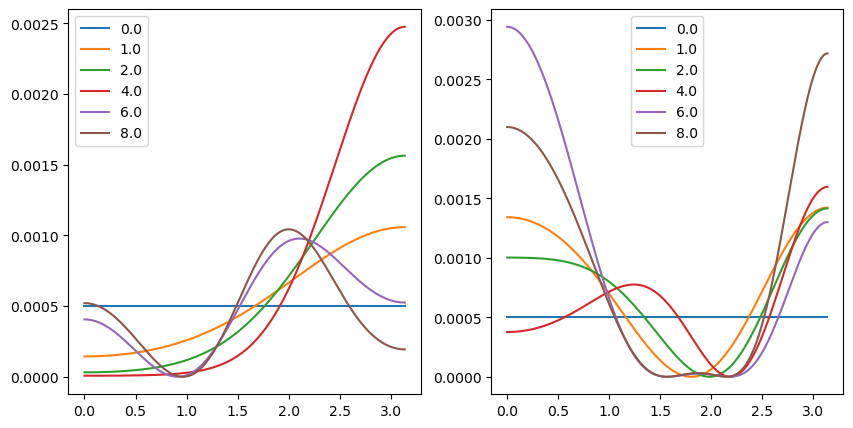

In [82]:
thetastep = math.pi / 1000
thetaRange = np.arange(0, math.pi, thetastep)

pState = 0
fig, ax = plt.subplots(1,2,figsize=(10,5))
for indexE, fieldE in enumerate(E_range):
    if fieldE in [0,1,2,4,6,8]:
    
        integral_sum = 0. 
        
        psiArr = np.zeros(len(thetaRange))
        for indexTh, theta in enumerate(thetaRange):
            phiSum = 0
            psiVal = system.getPsiM0(fieldE=indexE, pState=pState, theta=theta)
            term = abs(psiVal)**2
            integral_sum += term * math.sin(theta) * thetastep
            psiArr[indexTh] = term
            
        print(integral_sum)
        ax[0].plot(thetaRange, psiArr, label = str(fieldE))
ax[0].legend()        

pState = 2
for indexE, fieldE in enumerate(E_range):
    if fieldE in [0,1,2,4,6,8]:
    
        integral_sum = 0. 
        
        psiArr = np.zeros(len(thetaRange))
        for indexTh, theta in enumerate(thetaRange):
            phiSum = 0
            psiVal = system.getPsiM0(fieldE=indexE, pState=pState, theta=theta)
            term = abs(psiVal)**2
            integral_sum += term * math.sin(theta) * thetastep
            psiArr[indexTh] = term
            
        print(integral_sum)
        ax[1].plot(thetaRange, psiArr, label = str(fieldE))
ax[1].legend()

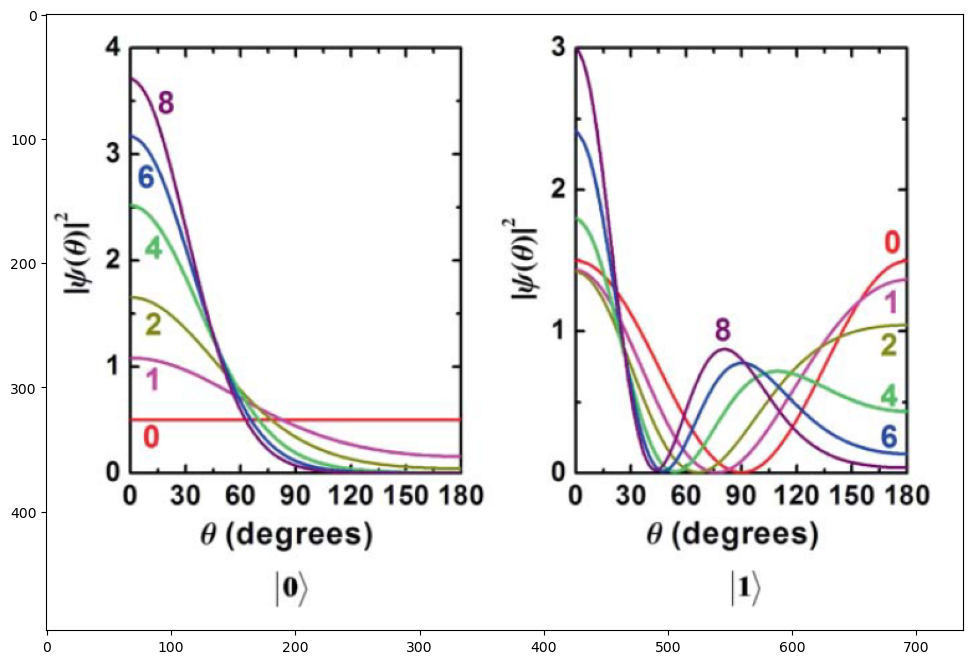

In [ ]:
plt.figure(figsize=(20,8))
img = mpimg.imread('Wei3.png')
imgplot = plt.imshow(img)
plt.show()

0.9997532314731729
0.9951474291180643
0.9941461815705059
0.9972643494336063
0.9844713414787479
0.9969226578867545


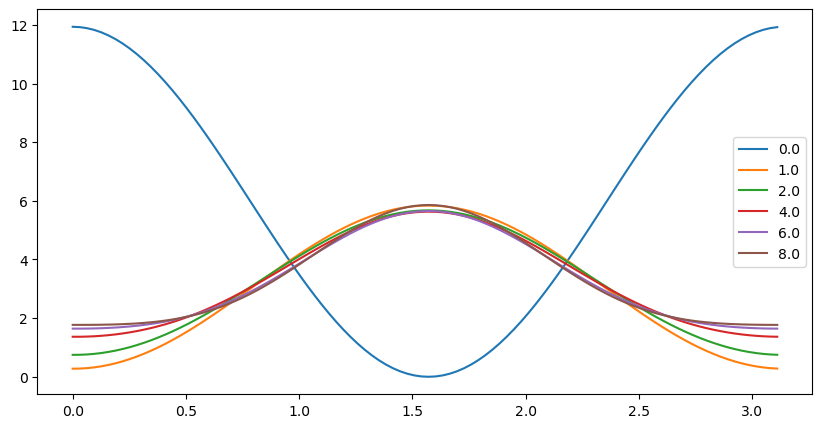

In [39]:
thetastep = math.pi / 100
thetaRange = np.arange(0, math.pi, thetastep)

phistep = 2*math.pi / 100
phiRange = np.arange(0, math.pi, phistep)

pState = 2
plt.figure(figsize=(10,5))
for indexE, fieldE in enumerate(E_range):
    if fieldE in [0,1,2,4,6,8]:
    
        integral_sum = 0. 
        
        psiArr = np.zeros(len(thetaRange))
        for indexTh, theta in enumerate(thetaRange):
            phiSum = 0
            for phi in phiRange:
                psiVal = system.getPsi(fieldE=indexE, pState=pState, theta=theta, phi = phi)
                term = abs(psiVal)**2
                
                phiSum += term
                integral_sum += term * 2 * math.sin(theta) * thetastep * phistep
            psiArr[indexTh] = phiSum.real
            
        print(integral_sum)
        plt.plot(thetaRange, psiArr, label = str(fieldE))
plt.legend()

In [ ]:
import cmath

In [ ]:
values = np.zeros((100,50))
phases = np.zeros((100,50))

maxval = -1e6
minval = 1e6
n, m = 1, 0

for i, phi in enumerate(np.arange(0, 2*math.pi, 2*math.pi/100.)):
    for j, theta in enumerate(np.arange(0, math.pi, math.pi/50.)):
        val = sph_harm(m,n,phi,theta)
        if val > maxval:
            maxval = val
        if val < minval:
            minval = val
            
        values[i][j] = abs(val)
        phases[i][j] = cmath.phase(val)

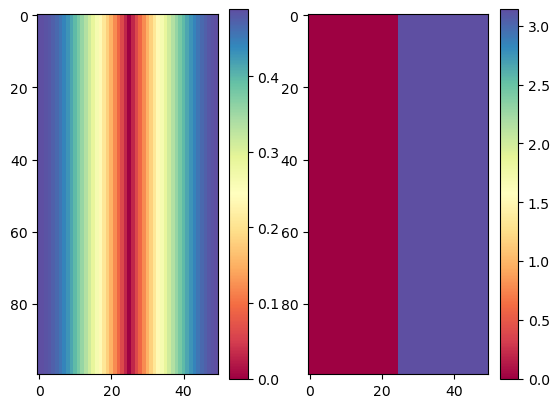

In [ ]:
fig, ax = plt.subplots(1,2)
cax0 = ax[0].imshow(values, cmap='Spectral')
plt.colorbar(cax0)
cax1 = ax[1].imshow(phases, cmap='Spectral')
plt.colorbar(cax1)

In [ ]:
eigenvectors

[array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[ 9.99584071e-01,  3.86096167e-16,  1.69424293e-32, ...,
         -1.67624055e-49,  2.46683933e-37, -3.77335944e-28],
        [ 0.00000000e+00,  9.99937513e-01, -2.73317081e-14, ...,
          4.65993806e-28, -4.33721317e-21,  8.62131303e-19],
        [ 2.88378966e-02, -1.34397145e-14, -1.13320552e-30, ...,
         -4.86795591e-44,  1.00958002e-32, -1.00237632e-21],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.23004242e-23,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          8.44476495e-27,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, 